In [1]:
# imdb_reviews  : tfds 사용
# binary sentiment classification  : 0(부정), 1(긍정)
# http://ai.stanford.edu/~amaas/data/sentiment/
# training : 25,000 reviews
# testingg : 25,000 reviews

In [2]:
import tensorflow as tf

# !pip install -q tensorflow-datasets

In [3]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)
# info
# 약 131MB

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling imdb_reviews-train.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling imdb_reviews-test.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling imdb_reviews-unsupervised.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to C:\Users\storm\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


In [4]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
    training_sentences.append(s.numpy().decode('utf8'))
    training_labels.append(l.numpy())

for s,l in test_data:
    testing_sentences.append(s.numpy().decode('utf8'))
    testing_labels.append(l.numpy())
    
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

print(len(training_sentences))
print(len(testing_sentences))
training_labels[:10]

25000
25000


[0, 0, 0, 1, 1, 1, 0, 0, 0, 0]

In [5]:
vocab_size = 10000
embedding_dim = 16
# max_length = 120
max_length = 500
trunc_type='post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)


In [6]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[3]))
print(training_sentences[3])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? this is the kind of film for a snowy sunday afternoon when the rest of the world can go ahead with its own business as you <OOV> into a big arm chair and <OOV> for a couple of ho

In [7]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(6, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])
# model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# model.summary()
# val_loss: 0.6630 - val_accuracy: 0.8668

In [8]:
# 모델 개선
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

# val_loss: 0.5199 - val_accuracy: 0.8717

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 16)           160016    
_________________________________________________________________
dropout (Dropout)            (None, 500, 16)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 496, 64)           5184      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 124, 64)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 198,289
Trainable params: 198,289
Non-trainable params: 0
__________________________________________________

In [9]:
# GPU : 약 4분 , CPU : 약 11~12분 
num_epochs = 10
history = model.fit(padded, 
                  training_labels_final, 
                  epochs=num_epochs, 
                  validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 49s 60ms/step - loss: 0.3972 - accuracy: 0.8065 - val_loss: 0.2809 - val_accuracy: 0.8868
Epoch 2/10
782/782 [==============================] - 51s 65ms/step - loss: 0.2159 - accuracy: 0.9168 - val_loss: 0.2687 - val_accuracy: 0.8898
Epoch 3/10
782/782 [==============================] - 54s 69ms/step - loss: 0.1552 - accuracy: 0.9440 - val_loss: 0.2977 - val_accuracy: 0.8819
Epoch 4/10
782/782 [==============================] - 59s 75ms/step - loss: 0.1184 - accuracy: 0.9590 - val_loss: 0.3231 - val_accuracy: 0.8802
Epoch 5/10
782/782 [==============================] - 60s 77ms/step - loss: 0.0929 - accuracy: 0.9676 - val_loss: 0.4024 - val_accuracy: 0.8660
Epoch 6/10
782/782 [==============================] - 60s 76ms/step - loss: 0.0718 - accuracy: 0.9772 - val_loss: 0.4186 - val_accuracy: 0.8732
Epoch 7/10
782/782 [==============================] - 75s 96ms/step - loss: 0.0597 - accuracy: 0.9802 - val_loss: 0.4676 - val_accuracy:

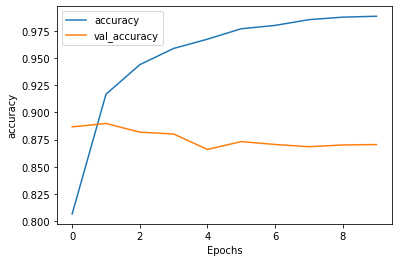

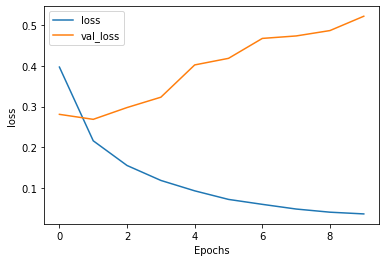

In [10]:
# 시각화
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [11]:
# 평가
model.evaluate(testing_padded,testing_labels_final)

782/782 [==============================] - 14s 18ms/step - loss: 0.5221 - accuracy: 0.8704


[0.5221401453018188, 0.8704400062561035]

In [12]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10001, 16)


In [13]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [14]:
sentence = "I really think this is amazing. honest."
sequence = tokenizer.texts_to_sequences([sentence])
print(sequence)

[[11, 64, 102, 12, 7, 478, 1200]]


In [15]:
# 예측 함수
import re

word_to_index = word_index
max_len = max_length

def sentiment_predict(new_sentence):
    # 알파벳과 숫자를 제외하고 모두 제거 및 알파벳 소문자화
    new_sentence = re.sub('[^0-9a-zA-Z ]', '', new_sentence).lower()

    # 정수 인코딩
    encoded = []
    for word in new_sentence.split():
    # 단어 집합의 크기를 10,000으로 제한.
        try :
            if word_to_index[word] <= 10000:
                encoded.append(word_to_index[word]+3)
            else:
        # 10,000 이상의 숫자는 <unk> 토큰으로 취급.
                encoded.append(2)
        # 단어 집합에 없는 단어는 <unk> 토큰으로 취급.
        except KeyError:
            encoded.append(2)

    pad_new = pad_sequences([encoded], maxlen = max_len) # 패딩
    score = float(model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [16]:
temp_str = "This movie was just way too overrated. The fighting was not professional and in slow motion. I was expecting more from a 200 million budget movie. The little sister of T.Challa was just trying too hard to be funny. The story was really dumb as well. Don't watch this movie if you are going because others say its great unless you are a Black Panther fan or Marvels fan."

sentiment_predict(temp_str)

99.78% 확률로 부정 리뷰입니다.


In [17]:
temp_str = " I was lucky enough to be included in the group to see the advanced screening in Melbourne on the 15th of April, 2012. And, firstly, I need to say a big thank-you to Disney and Marvel Studios. \
Now, the film... how can I even begin to explain how I feel about this film? It is, as the title of this review says a 'comic book triumph'. I went into the film with very, very high expectations and I was not disappointed. \
Seeing Joss Whedon's direction and envisioning of the film come to life on the big screen is perfect. The script is amazingly detailed and laced with sharp wit a humor. The special effects are literally mind-blowing and the action scenes are both hard-hitting and beautifully choreographed."

sentiment_predict(temp_str)

99.89% 확률로 부정 리뷰입니다.


In [18]:
# predict with very short sentecne
temp_str = "I hate this movie."
sentiment_predict(temp_str)

54.27% 확률로 부정 리뷰입니다.


In [19]:
# predict with very short sentecne
temp_str = "It's a perfect movie."
sentiment_predict(temp_str)

60.53% 확률로 긍정 리뷰입니다.
